/home/djoser/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


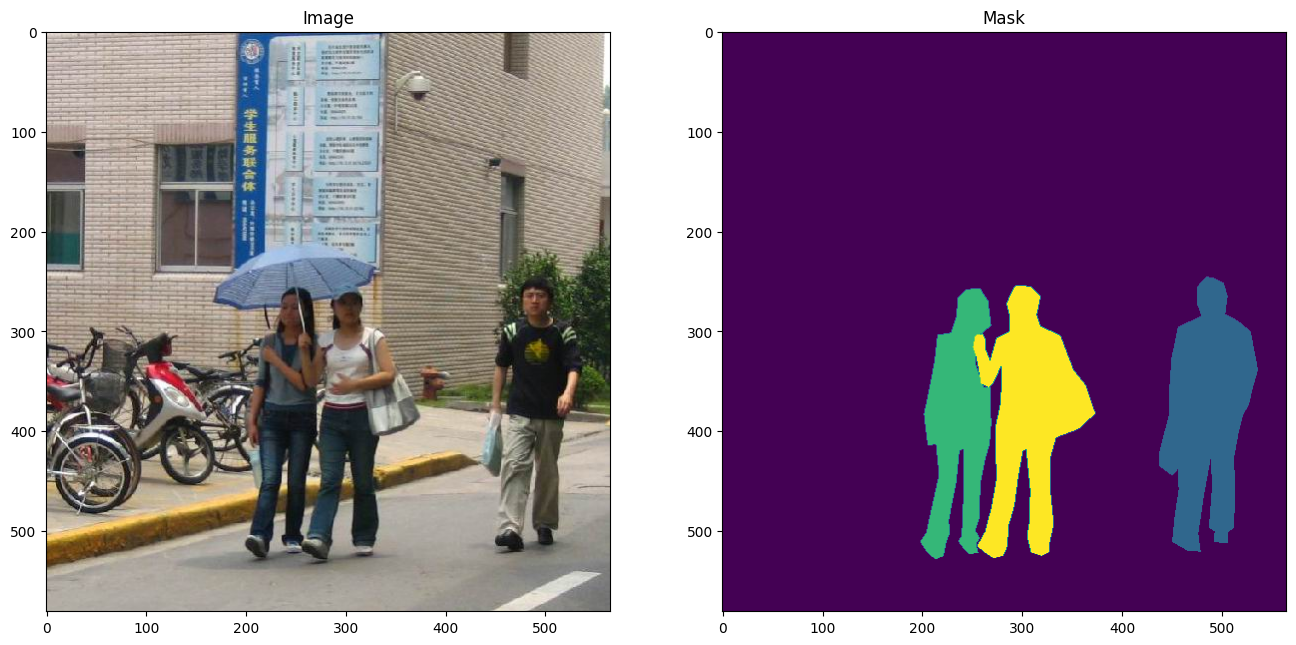

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00056.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00056_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))


In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        #print (boxes[0])

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [6]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [7]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1792, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0472, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0431, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.cuda.empty_cache() 
print("That's it!")

/home/djoser/Documents/Soccer_vision/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:01:08  lr: 0.000090  loss: 3.5544 (3.5544)  loss_classifier: 0.4810 (0.4810)  loss_box_reg: 0.2430 (0.2430)  loss_mask: 2.8256 (2.8256)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.1466  data: 0.0105  max mem: 1733
Epoch: [0]  [10/60]  eta: 0:00:31  lr: 0.000936  loss: 1.5405 (1.9481)  loss_classifier: 0.3756 (0.3447)  loss_box_reg: 0.3098 (0.3256)  loss_mask: 0.8106 (1.2518)  loss_objectness: 0.0232 (0.0211)  loss_rpn_box_reg: 0.0037 (0.0048)  time: 0.6250  data: 0.0176  max mem: 2570
Epoch: [0]  [20/60]  eta: 0:00:23  lr: 0.001783  loss: 0.8915 (1.3140)  loss_classifier: 0.1781 (0.2446)  loss_box_reg: 0.2718 (0.2809)  loss_mask: 0.3054 (0.7661)  loss_objectness: 0.0122 (0.0179)  loss_rpn_box_reg: 0.0036 (0.0045)  time: 0.5655  data: 0.0160  max mem: 2570
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.5314 (1.0442)  loss_classifier: 0.0738 (0.1865)  loss_box_reg: 0.2010 (0.2592)  loss_mask: 0.1983 (0.5802)  loss_ob

OutOfMemoryError: CUDA out of memory. Tried to allocate 174.00 MiB. GPU 0 has a total capacity of 3.61 GiB of which 58.75 MiB is free. Including non-PyTorch memory, this process has 3.53 GiB memory in use. Of the allocated memory 2.65 GiB is allocated by PyTorch, and 766.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

torch.save(model, "save_models/player_detector.pt")

In [8]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
n=104525
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

image1 = read_image(f"data/match1/angle1/frame_{n:08d}.png")
image2 = read_image(f"data/match1/angle2/frame_{n+55:08d}.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x1 = eval_transform(image1)
    # convert RGBA -> RGB and move to device
    x1 = x1[:3, ...].to(device)
    predictions1 = model([x1, ])
    pred1 = predictions1[0]


    x2 = eval_transform(image2)
    # convert RGBA -> RGB and move to device
    x2 = x2[:3, ...].to(device)
    predictions2 = model([x2, ])
    pred2 = predictions2[0]


image1 = (255.0 * (image1 - image1.min()) / (image1.max() - image1.min())).to(torch.uint8)
image2 = (255.0 * (image2 - image2.min()) / (image2.max() - image2.min())).to(torch.uint8)
image1 = image1[:3, ...]
image2 = image2[:3, ...]
pred_labels1 = [f"pedestrian: {score:.3f}" for label, score in zip(pred1["labels"], pred1["scores"])]
pred_labels2 = [f"pedestrian: {score:.3f}" for label, score in zip(pred2["labels"], pred2["scores"])]
pred_boxes1 = pred1["boxes"].long()
pred_boxes2 = pred2["boxes"].long()
output_image1 = draw_bounding_boxes(image1, pred_boxes1, pred_labels1, colors="red")
output_image2 = draw_bounding_boxes(image2, pred_boxes2, pred_labels2, colors="red")

masks1 = (pred1["masks"] > 0.7).squeeze(1)
masks2 = (pred2["masks"] > 0.7).squeeze(1)
output_image1 = draw_segmentation_masks(output_image1, masks1, alpha=0.5, colors="blue")
output_image2 = draw_segmentation_masks(output_image2, masks2, alpha=0.5, colors="blue")



plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Angle n°1")
plt.imshow(output_image1.permute(1, 2, 0))
plt.subplot(122)
plt.title("Angle n°2")
plt.imshow(output_image2.permute(1, 2, 0))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

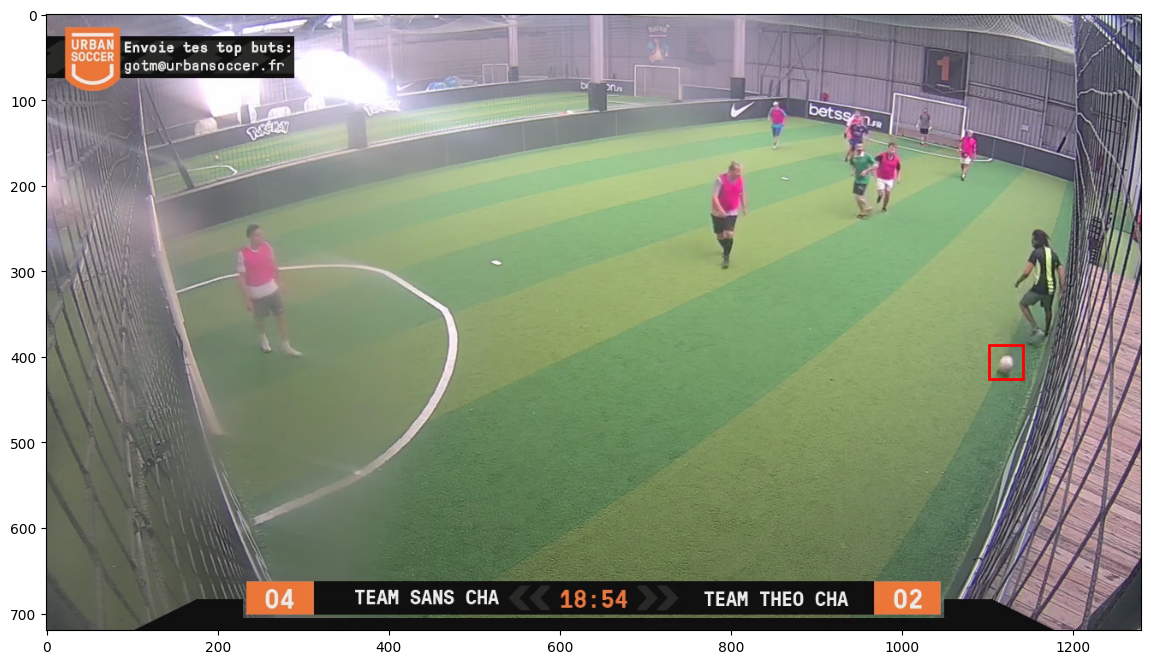

In [9]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os

def read_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    labels = []
    for line in lines:
        if line.startswith('Bounding box for object'):
            parts = line.split(':')[-1].strip().split('-')
            xmin, ymin = map(float, parts[0].strip(' ()').split(','))
            xmax, ymax = map(float, parts[1].strip(' ()').split(','))
            bboxes.append([xmin, ymin, xmax, ymax])
        elif line.startswith('Original label for object'):
            label = line.split(':')[-1].strip().strip('"')
            labels.append(label)

    return bboxes, labels

def draw_bboxes(image, bboxes):
    plt.figure(figsize=(16, 8))
    plt.imshow(image.permute(1, 2, 0))
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
    plt.show()
n=1056
# Paths to the image and annotation files
image_path = f"data/ball_target/angle1/images/frame_{n:08d}.png"
annotation_path = f"data/ball_target/angle1/annotations/frame_{n:08d}.txt"

# Read the image and annotations
image = read_image(image_path)
bboxes, labels = read_annotations(annotation_path)

# Draw bounding boxes on the image
draw_bboxes(image, bboxes)

In [10]:
def read_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    labels = []
    for line in lines:
        if line.startswith('Bounding box for object'):
            parts = line.split(':')[-1].strip().split('-')
            xmin, ymin = map(float, parts[0].strip(' ()').split(','))
            xmax, ymax = map(float, parts[1].strip(' ()').split(','))
            bboxes.append([xmin, ymin, xmax, ymax])
        elif line.startswith('Original label for object'):
            label = line.split(':')[-1].strip().strip('"')
            labels.append(label)

    return bboxes, labels

def draw_bboxes(image, bboxes):
    plt.figure(figsize=(16, 8))
    plt.imshow(image.permute(1, 2, 0))
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
    plt.show()

In [11]:
def create_mask(boxes, image_size):
    masks = []
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        mask = torch.zeros(image_size, dtype=torch.uint8)
        mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1
        masks.append(mask)
    return torch.stack(masks)

In [12]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class BallDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, limit=500):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.limit = limit
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.anots = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        #mask = read_image(mask_path)
        # instances are encoded as different colors
        #obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        #obj_ids = obj_ids[1:]
        num_objs = 1#len(obj_ids)
        annotation_path=img_path = os.path.join(self.root, "annotations", self.anots[idx])
        # split the color-encoded mask into a set
        # of binary masks
        #masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes,_ = read_annotations(annotation_path)
        boxes=torch.tensor(boxes, dtype=torch.int64)
        #print (boxes)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        masks = create_mask(boxes, img.shape[1:])

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
dataset = BallDataset('data/ball_target/angle1', get_transform(train=True))
_,y=dataset.__getitem__(1)
print(y['masks'])

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


In [14]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_ball_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [15]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = BallDataset('data/ball_target/angle1', get_transform(train=True))
dataset_test = BallDataset('data/ball_target/angle1', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model_1 = get_ball_model_instance_segmentation(num_classes)

# move model to the right device
model_1.to(device)

# construct an optimizer
params = [p for p in model_1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_1, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_1, data_loader_test, device=device)
    torch.cuda.empty_cache() 
print("That's it!")

/home/djoser/Documents/Soccer_vision/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [   0/1685]  eta: 0:36:50  lr: 0.000010  loss: 2.9270 (2.9270)  loss_classifier: 0.5936 (0.5936)  loss_box_reg: 0.0139 (0.0139)  loss_mask: 2.2290 (2.2290)  loss_objectness: 0.0618 (0.0618)  loss_rpn_box_reg: 0.0288 (0.0288)  time: 1.3117  data: 0.0370  max mem: 2219
Epoch: [0]  [  10/1685]  eta: 0:18:54  lr: 0.000060  loss: 2.0422 (2.1479)  loss_classifier: 0.5451 (0.5467)  loss_box_reg: 0.0139 (0.0144)  loss_mask: 1.3550 (1.5007)  loss_objectness: 0.0583 (0.0558)  loss_rpn_box_reg: 0.0277 (0.0302)  time: 0.6773  data: 0.0422  max mem: 2388
Epoch: [0]  [  20/1685]  eta: 0:17:56  lr: 0.000110  loss: 1.5786 (1.7876)  loss_classifier: 0.4283 (0.4203)  loss_box_reg: 0.0117 (0.0151)  loss_mask: 1.1474 (1.2669)  loss_objectness: 0.0506 (0.0549)  loss_rpn_box_reg: 0.0277 (0.0303)  time: 0.6131  data: 0.0433  max mem: 2388
Epoch: [0]  [  30/1685]  eta: 0:17:31  lr: 0.000160  loss: 1.0265 (1.4982)  loss_classifier: 0.1524 (0.3156)  loss_box_reg: 0.0164 (0.0170)  loss_mask: 0.7637 (

In [38]:
torch.save(model_1, "save_models/ball_detector_1.pt")

In [16]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = BallDataset('data/ball_target/angle2', get_transform(train=True))
dataset_test = BallDataset('data/ball_target/angle2', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model_2 = get_ball_model_instance_segmentation(num_classes)

# move model to the right device
model_2.to(device)

# construct an optimizer
params = [p for p in model_2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_2, data_loader_test, device=device)
    torch.cuda.empty_cache() 
print("That's it!")

Epoch: [0]  [   0/1446]  eta: 0:14:46  lr: 0.000010  loss: 12.1401 (12.1401)  loss_classifier: 0.7313 (0.7313)  loss_box_reg: 0.0136 (0.0136)  loss_mask: 11.3283 (11.3283)  loss_objectness: 0.0446 (0.0446)  loss_rpn_box_reg: 0.0223 (0.0223)  time: 0.6133  data: 0.0416  max mem: 2560
Epoch: [0]  [  10/1446]  eta: 0:14:38  lr: 0.000060  loss: 10.6239 (10.3684)  loss_classifier: 0.6999 (0.6796)  loss_box_reg: 0.0125 (0.0138)  loss_mask: 9.8258 (9.5657)  loss_objectness: 0.0567 (0.0833)  loss_rpn_box_reg: 0.0260 (0.0259)  time: 0.6115  data: 0.0410  max mem: 2729
Epoch: [0]  [  20/1446]  eta: 0:14:34  lr: 0.000110  loss: 2.7668 (6.2017)  loss_classifier: 0.5324 (0.5349)  loss_box_reg: 0.0139 (0.0172)  loss_mask: 2.1129 (5.5460)  loss_objectness: 0.0669 (0.0782)  loss_rpn_box_reg: 0.0255 (0.0253)  time: 0.6134  data: 0.0426  max mem: 2729
Epoch: [0]  [  30/1446]  eta: 0:14:28  lr: 0.000160  loss: 1.1063 (4.5044)  loss_classifier: 0.1978 (0.4011)  loss_box_reg: 0.0202 (0.0173)  loss_mask: 0.

In [37]:
torch.save(model_2, "save_models/ball_detector_2.pt")


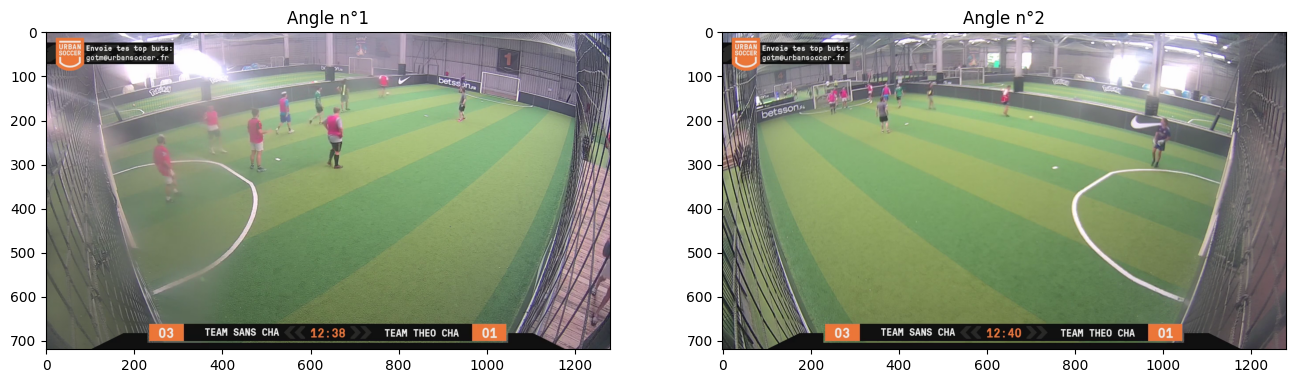

In [43]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
n=22770

image1 = read_image(f"data/match1/angle1/frame_{n:08d}.png")
image2 = read_image(f"data/match1/angle2/frame_{n+55:08d}.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x1 = eval_transform(image1)
    # convert RGBA -> RGB and move to device
    x1 = x1[:3, ...].to(device)
    predictions1 = model_1([x1, ])
    pred1 = predictions1[0]


    x2 = eval_transform(image2)
    # convert RGBA -> RGB and move to device
    x2 = x2[:3, ...].to(device)
    predictions2 = model_2([x2, ])
    pred2 = predictions2[0]


image1 = (255.0 * (image1 - image1.min()) / (image1.max() - image1.min())).to(torch.uint8)
image2 = (255.0 * (image2 - image2.min()) / (image2.max() - image2.min())).to(torch.uint8)
image1 = image1[:3, ...]
image2 = image2[:3, ...]
pred_labels1 = [f"pedestrian: {score:.3f}" for label, score in zip(pred1["labels"], pred1["scores"])]
pred_labels2 = [f"pedestrian: {score:.3f}" for label, score in zip(pred2["labels"], pred2["scores"])]
pred_boxes1 = pred1["boxes"].long()
pred_boxes2 = pred2["boxes"].long()
output_image1 = draw_bounding_boxes(image1, pred_boxes1, pred_labels1, colors="red")
output_image2 = draw_bounding_boxes(image2, pred_boxes2, pred_labels2, colors="red")

masks1 = (pred1["masks"] > 0.7).squeeze(1)
masks2 = (pred2["masks"] > 0.7).squeeze(1)
output_image1 = draw_segmentation_masks(output_image1, masks1, alpha=0.5, colors="blue")
output_image2 = draw_segmentation_masks(output_image2, masks2, alpha=0.5, colors="blue")



plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Angle n°1")
plt.imshow(output_image1.permute(1, 2, 0))
plt.subplot(122)
plt.title("Angle n°2")
plt.imshow(output_image2.permute(1, 2, 0))